[INFO] [1727380979.136304418] [rosbag2_storage]: Opened database '/home/rgautham20/ros2_ws_lab1/walking_data/walking_data_0.db3' for READ_ONLY.


    UTM_easting  UTM_northing
0      0.000000      0.000000
1      0.000000      0.000000
2      0.136758      0.185457
3      0.409738      0.741431
4      0.958379      0.928082
..          ...           ...
90    51.733813     56.408634
91    52.281373     56.965407
92    52.692177     57.336723
93    53.101906     58.078157
94    53.650003     58.449871

[95 rows x 2 columns]
UTM Easting - Mean: 26.099072861483958, Std Dev: 16.652567828386466, Median: 26.570668491651304, Mode: 0.0
UTM Northing - Mean: 24.916723602000427, Std Dev: 18.081270407682723, Median: 22.284365000203252, Mode: 0.0
Correlation between UTM_easting and UTM_northing: 0.9924270772811947
Linear Regression: Slope = 1.0775720915328781, Intercept = -3.206908928417821, R-squared = 0.9849115037208949, P-value = 1.6857752940443152e-86


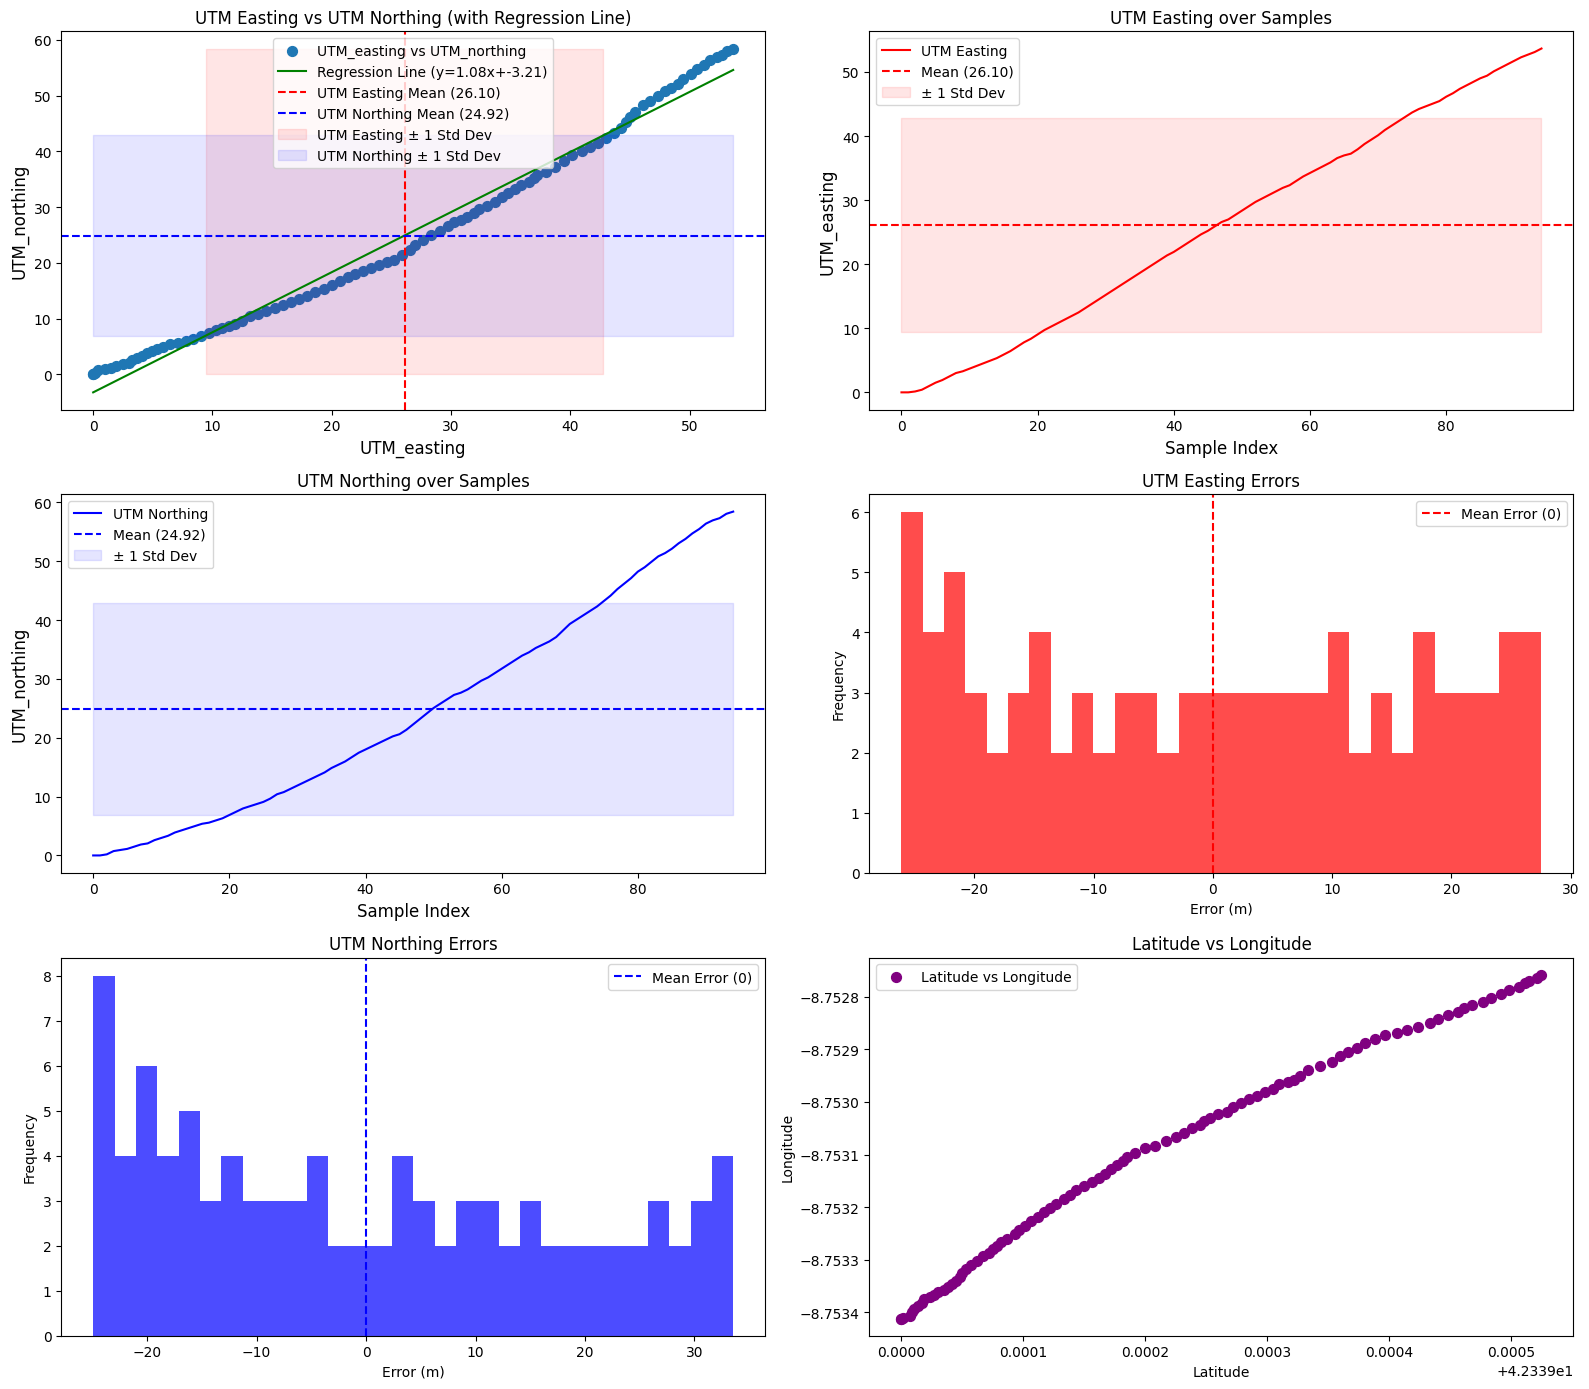

In [2]:
import rosbag2_py
import pandas as pd
import matplotlib.pyplot as plt
from gps_msgs.msg import GPSmsg
from rclpy.serialization import deserialize_message
from scipy import stats  # For regression and mode

# Define a function to read data from ROS 2 bag
def read_rosbag2_data(bag_path, topic_name):
    reader = rosbag2_py.SequentialReader()
    
    # Open the bag file
    storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id='sqlite3')
    converter_options = rosbag2_py.ConverterOptions('', '')
    reader.open(storage_options, converter_options)
    
    # Initialize variables to hold the data
    gps_data = []
    
    while reader.has_next():
        (topic, data, timestamp) = reader.read_next()
        if topic == topic_name:
            msg = deserialize_message(data, GPSmsg)  # Adjust based on your message type
            gps_data.append(msg)

    return gps_data

# Path to the bag file
bag_path = '/home/rgautham20/ros2_ws_lab1/walking_data/walking_data_0.db3'
topic_name = '/gps'  # Replace with your actual topic name

# Call the function to get the GPS data
gps_data = read_rosbag2_data(bag_path, topic_name)

# Process the GPS data as a list of dictionaries
gps_list = []

# Iterate through the list of GPSmsg and extract the data
for msg in gps_data:
    # Extract the necessary fields from each GPSmsg object
    gps_list.append({
        'UTM_easting': msg.utm_easting,
        'UTM_northing': msg.utm_northing,
        'latitude': msg.latitude,
        'longitude': msg.longitude,
        'altitude': msg.altitude
    })

# Convert the list of dictionaries to a Pandas DataFrame
readings = pd.DataFrame(gps_list)

# Normalize the UTM coordinates by subtracting the minimum value
readings['UTM_easting'] = readings['UTM_easting'] - readings['UTM_easting'].min()
readings['UTM_northing'] = readings['UTM_northing'] - readings['UTM_northing'].min()

# Print the UTM easting and northing columns for inspection
print(readings[['UTM_easting', 'UTM_northing']])

# Calculate various statistical parameters for UTM_easting and UTM_northing
utm_easting_mean = readings['UTM_easting'].mean()
utm_easting_std = readings['UTM_easting'].std()
utm_easting_median = readings['UTM_easting'].median()
utm_easting_mode = stats.mode(readings['UTM_easting'])[0]

utm_northing_mean = readings['UTM_northing'].mean()
utm_northing_std = readings['UTM_northing'].std()
utm_northing_median = readings['UTM_northing'].median()
utm_northing_mode = stats.mode(readings['UTM_northing'])[0]

# Calculate correlation coefficient between UTM_easting and UTM_northing
correlation = readings['UTM_easting'].corr(readings['UTM_northing'])

# Perform linear regression between UTM_easting and UTM_northing
slope, intercept, r_value, p_value, std_err = stats.linregress(readings['UTM_easting'], readings['UTM_northing'])

# Display calculated statistics
print(f"UTM Easting - Mean: {utm_easting_mean}, Std Dev: {utm_easting_std}, Median: {utm_easting_median}, Mode: {utm_easting_mode}")
print(f"UTM Northing - Mean: {utm_northing_mean}, Std Dev: {utm_northing_std}, Median: {utm_northing_median}, Mode: {utm_northing_mode}")
print(f"Correlation between UTM_easting and UTM_northing: {correlation}")
print(f"Linear Regression: Slope = {slope}, Intercept = {intercept}, R-squared = {r_value**2}, P-value = {p_value}")

# Set up the figure size
plt.figure(figsize=(16, 14))

# Subplot 1: UTM_easting vs UTM_northing scatter plot with regression line
plt.subplot(3, 2, 1)  # 3 rows, 2 columns, 1st subplot
plt.scatter(readings['UTM_easting'], readings['UTM_northing'], s=50, label='UTM_easting vs UTM_northing')
plt.plot(readings['UTM_easting'], slope * readings['UTM_easting'] + intercept, color='g', label=f'Regression Line (y={slope:.2f}x+{intercept:.2f})')
plt.axvline(utm_easting_mean, color='r', linestyle='--', label=f'UTM Easting Mean ({utm_easting_mean:.2f})')
plt.axhline(utm_northing_mean, color='b', linestyle='--', label=f'UTM Northing Mean ({utm_northing_mean:.2f})')

# Fill areas to indicate the standard deviation
plt.fill_betweenx(
    readings['UTM_northing'], 
    utm_easting_mean - utm_easting_std, 
    utm_easting_mean + utm_easting_std, 
    color='r', alpha=0.1, label='UTM Easting ± 1 Std Dev'
)

plt.fill_between(
    readings['UTM_easting'], 
    utm_northing_mean - utm_northing_std, 
    utm_northing_mean + utm_northing_std, 
    color='b', alpha=0.1, label='UTM Northing ± 1 Std Dev'
)

plt.xlabel('UTM_easting', fontsize=12)
plt.ylabel('UTM_northing', fontsize=12)
plt.title('UTM Easting vs UTM Northing (with Regression Line)')
plt.legend()

# Subplot 2: UTM_easting plot
plt.subplot(3, 2, 2)  # 3 rows, 2 columns, 2nd subplot
plt.plot(readings.index, readings['UTM_easting'], color='r', label='UTM Easting')
plt.axhline(utm_easting_mean, color='r', linestyle='--', label=f'Mean ({utm_easting_mean:.2f})')
plt.fill_between(readings.index, utm_easting_mean - utm_easting_std, utm_easting_mean + utm_easting_std, 
                 color='r', alpha=0.1, label='± 1 Std Dev')

plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('UTM_easting', fontsize=12)
plt.title('UTM Easting over Samples')
plt.legend()

# Subplot 3: UTM_northing plot
plt.subplot(3, 2, 3)  # 3 rows, 2 columns, 3rd subplot
plt.plot(readings.index, readings['UTM_northing'], color='b', label='UTM Northing')
plt.axhline(utm_northing_mean, color='b', linestyle='--', label=f'Mean ({utm_northing_mean:.2f})')
plt.fill_between(readings.index, utm_northing_mean - utm_northing_std, utm_northing_mean + utm_northing_std, 
                 color='b', alpha=0.1, label='± 1 Std Dev')

plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('UTM_northing', fontsize=12)
plt.title('UTM Northing over Samples')
plt.legend()

# Subplot 4: UTM Easting Errors Histogram
plt.subplot(3, 2, 4)  # 3 rows, 2 columns, 4th subplot
easting_errors = readings['UTM_easting'] - utm_easting_mean
plt.hist(easting_errors, bins=30, color='r', alpha=0.7)
plt.axvline(0, color='r', linestyle='--', label='Mean Error (0)')
plt.title('UTM Easting Errors')
plt.xlabel('Error (m)')
plt.ylabel('Frequency')
plt.legend()

# Subplot 5: UTM Northing Errors Histogram
plt.subplot(3, 2, 5)  # 3 rows, 2 columns, 5th subplot
northing_errors = readings['UTM_northing'] - utm_northing_mean
plt.hist(northing_errors, bins=30, color='b', alpha=0.7)
plt.axvline(0, color='b', linestyle='--', label='Mean Error (0)')
plt.title('UTM Northing Errors')
plt.xlabel('Error (m)')
plt.ylabel('Frequency')
plt.legend()

# Subplot 6: Latitude vs Longitude plot
plt.subplot(3, 2, 6)  # 3 rows, 2 columns, 6th subplot
plt.scatter(readings['latitude'], readings['longitude'], s=50, color='purple', label='Latitude vs Longitude')
plt.title('Latitude vs Longitude')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()